In [1]:
%matplotlib inline

In [2]:
import fns
from fns import *
from fns.functionsTFhardbound import *

/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


********************************************************************************
functionsTFhardbound loaded!
********************************************************************************


In [3]:
PAPER = os.path.expanduser('~/Dropbox/ICL-2014/Presentations/2016-10-11-GJ-sync-paper/figures/')

## Activity Phase Diagrams

In [54]:
i = 0
params = []
for T in [1000]:
        for N in [1000]:
            for g in np.arange(0, 15, 0.5):
                for nu in np.arange(0, 200, 5):
                        i += 1
                        params.append([T, N, g, nu, i])

scaling = 1 / (1 / (2 * 2 / 0.25)) ** 0.5 * 70

# 3->4: fix ratio g0 to 7

def runFnNoPlast(things):
    DEVICE = '/cpu:0'
    T, N, g, nu, i = things
#     apple = generateInput2(2, T)
#     print('*' * 80)
#     print('%d / %d' % (i, 160))
    ### input 1: apple
    
    tauv = 15
    sG = 0
    gpu1 = TfSingleNet(N=N, T=T, disp=False, tauv=15, nu=nu, g0=g, 
                       device=DEVICE, spikeMonitor=True, startPlast=999999)
    gpu1.input = np.zeros(T)
    gpu1.initWGap = False
    gpu1.runTFSimul()

    filename = "../data/PhasePlan5/PhasePlan6_nu-%d_g-%.2f_N-%d_input-%s_T-%d" % (nu, g, N, 'noise', T)
    with open(filename, 'wb') as f:
        np.savez(f, vvm=gpu1.vvm, 
                 i=gpu1.im, 
                 bursts=gpu1.lowsp,
                 burstA=gpu1.burstingActivity, 
                 spikeA=gpu1.spikingActivity)
        
    filename = "../data/rasters/rasterPhasePlan6_nu-%d-tauv-%d_g-%.2f_N-%d_T-%d" % (nu, tauv, g, N, T)
    with open(filename, 'wb') as f:
        r = np.array(gpu1.raster)
        r = r.reshape(r.shape[0], r.shape[1]).transpose()
        np.save(f, r)
        
    del gpu1

p = Pool(nodes=56)
re = p.amap(runFnNoPlast, params)
re.get()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

array(0.02603599987924099, dtype=float32)

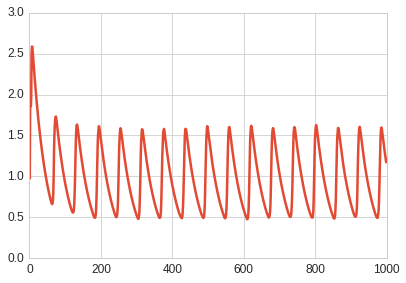

In [35]:
g=10
filename = "../data/PhasePlan5/PhasePlan6_nu-%d_g-%.2f_N-%d_input-%s_T-%d" % (nu, g, N, 'noise', T)
a = np.load(filename)
b = a['bursts'].reshape(T,N).transpose()
plt.plot(np.mean(b[:,:],axis=0))
a['spikeA']

In [62]:
df = pd.DataFrame(columns=('nu', 'g', 'T', 'N', 'f', 'p', 'burst', 'spike', 'ratio', 'b2','r2'
                          ) )
i=-1
d = 2000
d2 = 7000
start = 5900
s0 = 100
sigma = 8
params=[]
for T in [1000]:
        for N in [1000]:
            for g in np.arange(0, 15, 0.5):
                for nu in np.arange(0, 200, 5):
                        i+=1
                        params.append([T, N, g, nu, i])

def getDF(params):
    T, N, g, nu, i = params
    filename = "../data/PhasePlan5/PhasePlan6_nu-%d_g-%.2f_N-%d_input-%s_T-%d" % (nu, g, N, 'noise', T)
    a = np.load(filename)
    I = a['i']

    # compute frequency and power with fourier transform of the lfp (mean current)
    f = fourier(I[10:])[0]
    p = fourier(I[10:])[1]
    b = a['bursts'].reshape(T,N).transpose()
    bm = np.mean(b[:,50:]>1.7)
    
    filename = "../data/rasters/rasterPhasePlan6_nu-%d-tauv-%d_g-%.2f_N-%d_T-%d" % (nu, 15, g, N, T)
    r = np.load(filename)[50:]
    lowSp=0
    lsp=[]
    lspm=[]
    dt=0.25
    for t in range(len(r)):
        tau = 8
        lowSp = lowSp + dt / tau * (r[:,t] * tau / dt - lowSp)
        lspm.append(np.mean(lowSp>1.5, axis=0))
        lsp.append(lowSp[10])
    bt = np.mean(lspm)
    
    
    return [i, int(nu), g, int(T), int(N), f, p, 
                 float(bm), float(a['spikeA']), (bm/a['spikeA']), float(bt), (bt/a['spikeA'])]
    
q = Pool(nodes=56)
re = q.amap(getDF, params)
res = re.get()
for r in res:
    df.loc[r[0]]=r[1:]

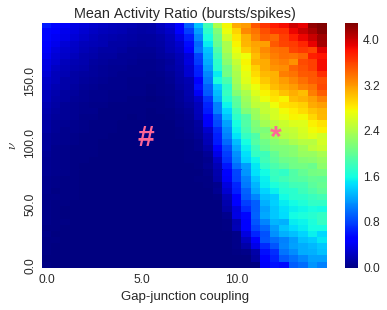

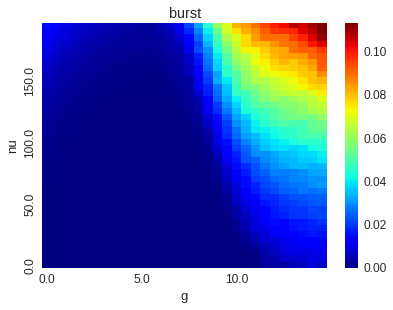

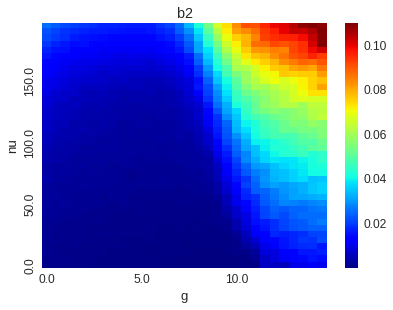

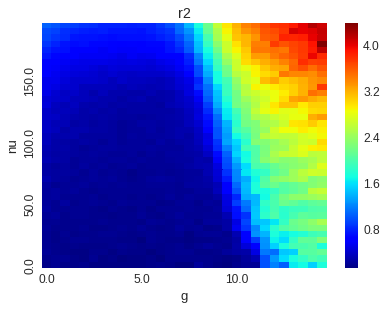

In [63]:
cols = ['f', 'p']
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

# df = df_[(df_['g']<3)&(df_['nu']<20)]
def setLabels(fig):
    color = '#FF6898'
    fig.text(5*2, 20, '#', fontweight='bold', fontsize=30, color=color)
    fig.text(12*2, 20, '*', fontweight='bold', fontsize=30, color=color)
    fig.set_ylabel(r'$\nu$')
    fig.set_xlabel(r'Gap-junction coupling')
    
    

# fig = plotHeatmap(df, col='f', y='nu', x='g', title='Frequency of strongest Fourier component')
# setLabels(fig)
# plt.savefig(PAPER + 'frequency.svg')

# fig = plotHeatmap(df, col='p', y='nu', x='g', title='Power of strongest Fourier component')
# setLabels(fig)
# plt.savefig(PAPER + 'power.svg')

fig = plotHeatmap(df, col='ratio', y='nu', x='g', title='Mean Activity Ratio (bursts/spikes)', 
                  cmap='jet')
setLabels(fig)
plt.savefig(PAPER + 'ratio.svg')

plotHeatmap(df, col='burst', y='nu', x='g', title='burst', cmap=plt.cm.jet)

# plotHeatmap(df, col='spike', y='nu', x='g', title='spike', cmap=plt.cm.jet)

plotHeatmap(df, col='b2', y='nu', x='g', title='b2', cmap=plt.cm.jet)

plotHeatmap(df, col='r2', y='nu', x='g', title='r2', cmap=plt.cm.jet)

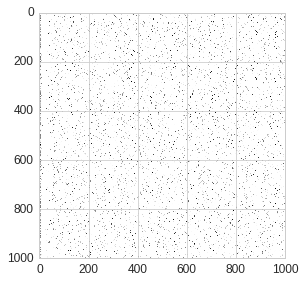

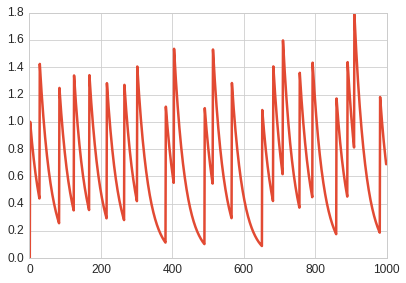

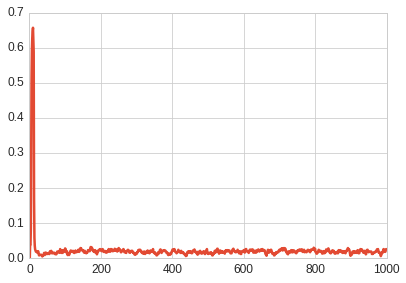

In [64]:
tauv =15
g=0.1
nu=190
filename = "../data/rasters/rasterPhasePlan5_nu-%d-tauv-%d_g-%d_N-%d_T-%d" % (nu, tauv, g, N, T)
r = np.load(filename)
plt.imshow(r)
lowSp=0
lsp = []
lspm = []
dt = 0.25
for i in range(len(r)):
    tau = 8
    lowSp = lowSp + dt / tau * (r[:,i] * tau / dt - lowSp)
    lspm.append(np.mean(lowSp>1.5, axis=0))
    lsp.append(lowSp[10])
    
plt.figure()
plt.plot(lsp)
plt.figure()
plt.plot(lspm)

In [15]:
df[df['nu']==100]

,nu,g,T,N,f,p,burst,spike,ratio
20,100.0,0.0,8000.0,1000.0,19.014258,-10.996376,0.028322,0.015385,1.840929
60,100.0,0.5,8000.0,1000.0,5.003752,-8.010653,0.024634,0.014970,1.645602
100,100.0,1.0,8000.0,1000.0,18.013508,-9.892727,0.021208,0.014589,1.453690
140,100.0,1.5,8000.0,1000.0,3.002251,-9.248868,0.018679,0.014213,1.314237
180,100.0,2.0,8000.0,1000.0,10.007504,-7.353106,0.016307,0.013847,1.177715
220,100.0,2.5,8000.0,1000.0,3.002251,-8.828474,0.014418,0.013502,1.067899
260,100.0,3.0,8000.0,1000.0,11.008255,-7.191382,0.012837,0.013155,0.975827
300,100.0,3.5,8000.0,1000.0,14.010506,-7.142781,0.011481,0.012821,0.895510
340,100.0,4.0,8000.0,1000.0,18.013508,-9.271971,0.010138,0.012490,0.811691
380,100.0,4.5,8000.0,1000.0,12.009005,-8.556871,0.009289,0.012191,0.761937


In [4]:
DEVICE = '/gpu:0'

T=1100
g=5
### input 1: apple
nu = 100
gpu1 = TfSingleNet(N=1000, T=T, disp=False, tauv=15, nu=nu, g0=g, 
                   device=DEVICE, spikeMonitor=True, startPlast=999999)
gpu1.input = np.ones(T)*0
gpu1.initWGap = False
gpu1.runTFSimul()

g=12
gpu2 = TfSingleNet(N=1000, T=T, disp=False, tauv=15, nu=nu, g0=g, 
                   device=DEVICE, spikeMonitor=True, startPlast=999999)
gpu2.input = np.ones(T)*0
gpu2.initWGap = False
gpu2.runTFSimul()

# filename = "raster_nu-%d_g-%d_N-%d_input-%s_T-%d" % (nu, g, N, 'raster', T)
# with open(filename, 'wb') as f:
#     np.savez(f, vvm=gpu1.vvm, i=gpu1.im, spikes=gpu1.spikes, burst=gpu1.burstingActivity, spike=gpu1.spikingActivity)
# del gpu1
# gc.collect()

7.99
7.64


In [5]:
# plt.style.available

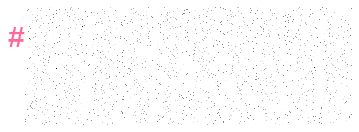

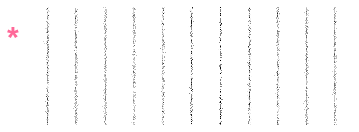

In [29]:

plt.style.use(['seaborn-white','seaborn-paper', 'ggplot'])
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

def setLabels(ax):
    ax.set_yticks([])
    ax.set_xticks([])
    
    
color = '#FF6898'
a = 5
b = 3
aspect = b/a
fig  = plt.figure(figsize=(a,b))
ax = fig.add_subplot(111)
ax.imshow(gpu1.raster[100:1100].transpose(), aspect=aspect)
setLabels(ax)
ax.text(-50, 400, '#', fontweight='bold', fontsize=30, color=color)
plt.gca().invert_yaxis()
plt.ylim([0,600])
plt.tight_layout()
# plt.tight_layout()
plt.savefig(PAPER + 'raster-AS.svg')

fig  = plt.figure(figsize=(a,b))
ax = fig.add_subplot(111)
ax.imshow(gpu2.raster[100:1100].transpose(), aspect=aspect)
setLabels(ax)
ax.text(-50, 400, '*', fontweight='bold', fontsize=30, color=color)
plt.gca().invert_yaxis()
plt.ylim([0,600])
plt.tight_layout()

# plt.tight_layout()
plt.savefig(PAPER + 'raster-S.svg')

In [38]:
# plt.style.use(['seaborn-white','seaborn-paper', 'ggplot'])
# sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})



# def setLabels(ax):
#     ax.set_yticks([])
#     ax.set_xticks([])
    
    
# color = '#FF6898'
# a = 5
# b = 3
# aspect = b/a
# fig  = plt.figure(figsize=(a,b))
# ax = fig.add_subplot(111)

# spikes = gpu1.raster[100:1100].transpose()
# y = np.concatenate([spikes[i,:]*(i+1) for i in range(spikes.shape[0])])
# x = list(np.arange(spikes.shape[1]))*spikes.shape[0]
# ax.plot(x,y, '.')
# setLabels(ax)
# ax.text(-50, 400, '#', fontweight='bold', fontsize=30, color=color)
# plt.gca().invert_yaxis()
# plt.ylim([0,600])
# plt.tight_layout()
# # plt.tight_layout()
# plt.savefig(PAPER + 'raster-AS.svg')

# # fig  = plt.figure(figsize=(a,b))
# # ax = fig.add_subplot(111)
# # ax.imshow(gpu2.raster[100:1100].transpose(), aspect=aspect)
# # setLabels(ax)
# # ax.text(-50, 400, '*', fontweight='bold', fontsize=30, color=color)
# # plt.gca().invert_yaxis()
# # plt.ylim([0,600])
# # plt.tight_layout()

# # plt.tight_layout()
# # plt.savefig(PAPER + 'raster-S.svg')

In [7]:
fourier(gpu2.vvm[100:])

[47.808764940239044, -43.811645135404746]

## FIG1

In [34]:
fig = sg.SVGFigure("16cm", "10cm")
# load matpotlib-generated figures
fig1 = sg.fromfile(PAPER + '/frequency.svg') #/2016-09-29-MakePhaseDiagramsWithTF.ipynb
fig2 = sg.fromfile(PAPER + '/power.svg') #/2016-09-29-MakePhaseDiagramsWithTF.ipynb
fig3 = sg.fromfile(PAPER + '/ratio.svg') #/2016-09-29-MakePhaseDiagramsWithTF.ipynb
fig4 = sg.fromfile(PAPER + 'coupling.svg')  # figure1D-coupling.ipynb
fig5 = sg.fromfile(PAPER + 'circuit.svg')  # drawing
fig6 = sg.fromfile(PAPER + 'resonance.svg') # figure1-resonant-property.ipynb
fig7 = sg.fromfile(PAPER + 'raster-AS.svg') # /2016-09-29-MakePhaseDiagramsWithTF.ipynb
fig8 = sg.fromfile(PAPER + 'raster-S.svg') # /2016-09-29-MakePhaseDiagramsWithTF.ipynb



# get the plot objects
scale = 0.45
plot1 = fig1.getroot()
plot1.moveto(0,10,scale= scale)

plot2 = fig2.getroot()
plot2.moveto(180, 10, scale = scale)

plot3 = fig3.getroot()
plot3.moveto(360, 10, scale = scale)

plot4 = fig4.getroot()
plot4.moveto(20,160, scale = scale)

plot5 = fig5.getroot()
plot5.moveto(145,185, scale = scale)

plot6 = fig6.getroot()
plot6.moveto(180,160, scale = scale)

plot7 = fig7.getroot()
plot7.moveto(400,170, scale = 0.3)

plot8 = fig8.getroot()
plot8.moveto(400,220, scale = 0.3)




# add text labels
w = "normal"
txt1 = sg.TextElement(5,20, "A", size=12, weight=w)
txt2 = sg.TextElement(190,20, "B", size=12, weight=w)
txt3 = sg.TextElement(370,20, "C", size=12, weight=w)
# txt4 = sg.TextElement(390,190, "#", size=12, weight=w)

# txt5 = sg.TextElement(390,240, "*", size=12, weight=w)
txt6 = sg.TextElement(370,165, "F", size=12, weight=w)
txt7 = sg.TextElement(190,165, "E", size=12, weight=w)
txt8 = sg.TextElement(5,165, "D", size=12, weight=w)
# append plots and labels to figure
fig.append([plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8])
fig.append([txt1, txt2, txt3, txt4, txt5, txt6, txt7, txt8])
# save generated SVG files
fig.save(PAPER + "fig1.svg")
svg2pdf('fig1',PAPER) 




In [35]:
def svg2png(filename, path = '/Users/GP1514/Dropbox/0000_PhD/figures/20160704/'):
    subprocess.check_output(["inkscape", '%s%s.svg'%(path, filename),
                            '-e', '%s%s.png'%(path,filename), '--without-gui',
                             '--export-ignore-filters','--export-png', '-d 300'])
    
svg2png('fig1',PAPER) 

## FIG2

## force power in subnet to see switch

In [16]:
i = 0
params = []
for T in [16000]:
    for both in [False]:
        for N in [1000]:
            for sG in np.arange(0, 100, 5):
                for tauv in np.arange(15, 90, 15):
                    for k in [0]:
                        i += 1
                        params.append([T, both, N, sG, tauv, i, k])

scaling = 1 / (1 / (2 * 2 / 0.25)) ** 0.5 * 70


df = pd.read_csv('gSteady.csv')

def runFnNoPlast(things):
    DEVICE = '/cpu:0'
    T, both, N, sG, tauv, i, k = things
    apple = generateInput2(2, T)
    pear = generateInput2(3, T)
    print('*' * 80)
    print('%d / %d' % (i, 160))
    ### input 1: apple
    gpu1 = TfConnEvolveNet(N=N, T=T, disp=False, tauv=tauv, sG=sG, device=DEVICE,
                 both=both, spikeMonitor=False, startPlast=8000)
    gpu1.input = apple*k
    gpu1.connectTime = 8000
    gpu1.FACT = 10**(-10)
    gpu1.initWGap = -1
    gpu1.g1 = 4.5
    gpu1.g2 = 3.5
    gpu1.disp = False
    
    gpu1.runTFSimul()
    

    filename = "Switch41-both-%s_tauv-%d_sg-%d_N-%d_input-%s_T-%d_k-%d" % (str(both), tauv, sG, N, 'noise', T, k)
    with open(filename, 'wb') as f:
        np.savez(f, vvmN1=gpu1.vvmN1, vvmN2=gpu1.vvmN2, vvm=gpu1.vvm,
                 g1N1=gpu1.gammaN1, g1N2 = gpu1.gammaN2, g1=gpu1.gamma, g1s=gpu1.gammaNS,
                 i1N1=gpu1.i1, i1N2=gpu1.i2, )
    del gpu1
    gc.collect()

p = Pool(nodes=56)
re = p.amap(runFnNoPlast, params)
re.get()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]